# File Setup

In [1]:
import geopandas as gpd
import shapely
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import fiona
import scipy
import pyarrow
import folium
from pyproj import Transformer
import branca 
from branca.colormap import LinearColormap
import rasterio
from folium.plugins import HeatMap
import matplotlib.colors as mcolors
import json
import pysmile
import pysmile_license
import xml.etree.ElementTree as ET
from graphviz import Digraph
import matplotlib
from scipy import stats

# Load one netcdf file to test

#### Load rain data 

In [2]:
rain_regions_dict = {
    3:'Waikato Region',
    6:"Hawke's Bay Region",
    8:'Manawatū-Whanganui Region',
    13:'Canterbury Region'
}


In [3]:
df_rainfall = pd.read_csv('VCSN_Region_GNS.csv')

In [4]:
rainfall_mean_dict = {}

for region,group_region in df_rainfall.groupby('region_N'):
    if region not in (rain_regions_dict.keys()):
        continue
    for q,group in group_region.groupby('q5rain30'):
        rainfall_mean_dict.update({
            (rain_regions_dict[region],q):round(np.mean(group.Rain_sum30day),0)
        })

In [5]:
df_mean_rain = pd.DataFrame.from_dict(rainfall_mean_dict,orient='index')
df_mean_rain['region'] = [x[0] for x in df_mean_rain.index]
df_mean_rain['quintile'] = [x[1] for x in df_mean_rain.index]
df_mean_rain = df_mean_rain.rename(columns={0:'mean_precip'})
# df_mean_rain = df_mean_rain.pivot('quintile',columns='region')
# df_mean_rain.columns = [x[1] for x in df_mean_rain.columns]
# df_mean_rain.T
df_mean_rain

,mean_precip,region,quintile
"(Waikato Region, 1)",299.0,Waikato Region,1
"(Waikato Region, 2)",594.0,Waikato Region,2
"(Waikato Region, 3)",873.0,Waikato Region,3
"(Waikato Region, 4)",1247.0,Waikato Region,4
"(Waikato Region, 5)",1887.0,Waikato Region,5
"(Hawke's Bay Region, 1)",297.0,Hawke's Bay Region,1
"(Hawke's Bay Region, 2)",585.0,Hawke's Bay Region,2
"(Hawke's Bay Region, 3)",864.0,Hawke's Bay Region,3
"(Hawke's Bay Region, 4)",1212.0,Hawke's Bay Region,4
"(Hawke's Bay Region, 5)",1805.0,Hawke's Bay Region,5


#### Load ground water data 

In [6]:
gdf_base_sfo = gpd.read_parquet('for_shannon/hpm_base4sb/hpm_base4sb_streams_sfo.pqt')
gdf_base_sfo = gdf_base_sfo.to_crs(4326)
gdf_base_sfx = gpd.read_parquet('for_shannon/hpm_base4sb/hpm_base4sb_streams_sfx.pqt')
gdf_base_sfx = gdf_base_sfx.to_crs(4326)
xr_base = xr.open_dataset('for_shannon/hpm_base4sb/hpm_base4sb.nc')

In [7]:
gdf_dry_sfo = gpd.read_parquet('for_shannon/hpm_dry4sb/hpm_dry4sb_streams_sfo.pqt')
gdf_dry_sfo = gdf_dry_sfo.to_crs(4326)
gdf_dry_sfx = gpd.read_parquet('for_shannon/hpm_dry4sb/hpm_dry4sb_streams_sfx.pqt')
gdf_dry_sfx = gdf_dry_sfx.to_crs(4326)
xr_dry = xr.open_dataset('for_shannon/hpm_dry4sb/hpm_dry4sb.nc')

In [8]:
gdf_wet_sfo = gpd.read_parquet('for_shannon/hpm_wet4sb/hpm_wet4sb_streams_sfo.pqt')
gdf_wet_sfo = gdf_wet_sfo.to_crs(4326)
gdf_wet_sfx = gpd.read_parquet('for_shannon/hpm_wet4sb/hpm_wet4sb_streams_sfx.pqt')
gdf_wet_sfx = gdf_wet_sfx.to_crs(4326)
xr_wet = xr.open_dataset('for_shannon/hpm_wet4sb/hpm_wet4sb.nc')

In [9]:
xr_dry['hds'] = xr_dry.hds.mean('realization',skipna=True)
xr_base['hds'] = xr_base.hds.mean('realization',skipna=True)
xr_wet['hds'] = xr_wet.hds.mean('realization',skipna=True)

In [10]:
df_health_outcomes = pd.read_csv('simon_data_cleaned.csv')
df_health_outcomes = df_health_outcomes.replace('Manawat?-Whanganui Region','Manawatū-Whanganui Region')

In [11]:
df_health_outcomes = pd.merge(df_health_outcomes,df_mean_rain,left_on=['Region','rainfall_quintile'],right_on=['region','quintile'])

In [12]:
gdf_lgas = gpd.read_file('statsnz-regional-council-2020-generalised-SHP/regional-council-2020-generalised.shp')
gdf_lgas = gdf_lgas[gdf_lgas['REGC2020_1'].isin(['Waikato Region',"Hawke's Bay Region","Manawatū-Whanganui Region","Canterbury Region"])]
gdf_lgas = pd.merge(gdf_lgas,df_health_outcomes,left_on='REGC2020_1',right_on='Region')
gdf_lgas = gdf_lgas.to_crs(4326)

gdf_lgas_q4 = gdf_lgas[gdf_lgas.rainfall_quintile==4]
gdf_lgas_q5 = gdf_lgas[gdf_lgas.rainfall_quintile==5]

geojson_data_4  = gdf_lgas_q4.to_json()
geojson_data_5  = gdf_lgas_q5.to_json()

In [13]:
def style_function(feature):
    cmap = plt.cm.get_cmap('Reds')
    
    rgb_color = cmap(feature['properties']['risk_increase']/100)
    hex_color = mcolors.rgb2hex(rgb_color)
    
    return {'fillColor': hex_color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}


In [14]:
def style_function_precip(feature):
    cmap = plt.cm.get_cmap('Blues')
    
    rgb_color = cmap((feature['properties']['mean_precip']-1000)/1000)
    hex_color = mcolors.rgb2hex(rgb_color)
    
    return {'fillColor': hex_color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}


In [15]:
gpd.read_parquet('for_shannon/hpm_base4sb/hpm_base4sb_streams_sfo.pqt').__getattr__('crs')

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Rainfall Data

In [16]:
df_rainfall = pd.read_csv('annual-and-seasonal-rainfall-at-30-sites-1960-to-2022.csv')

In [17]:
df_rainfall = df_rainfall[df_rainfall.site=="Napier (Hawke's Bay)"]

In [18]:
df_rainfall['period_start'] = [datetime.datetime(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2])) for x in df_rainfall.period_start]
df_rainfall['period_end'] = [datetime.datetime(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2])) for x in df_rainfall.period_end]

In [19]:
offset = datetime.timedelta(days=0)
base_start = datetime.datetime(1972,1,3)-offset
base_end = datetime.datetime(2021,12,31)-offset

wet_start = datetime.datetime(2018,7,1)-offset
wet_end = datetime.datetime(2019,6,30)-offset

dry_start = datetime.datetime(2020,7,1)-offset
dry_end = datetime.datetime(2021,6,30)-offset

In [20]:
df_rainfall_base = df_rainfall[(df_rainfall.period_start>=base_start)&(df_rainfall.period_end<=base_end)&(df_rainfall.season!='Annual')]
df_rainfall_wet = df_rainfall[(df_rainfall.period_end>=wet_start)&(df_rainfall.period_end<=wet_end)&(df_rainfall.season!='Annual')]
df_rainfall_dry = df_rainfall[(df_rainfall.period_end>=dry_start)&(df_rainfall.period_end<=dry_end)&(df_rainfall.season!='Annual')]

In [21]:
df_rainfall_wet

,site,season,precipitation,precipitation_units,period_start,period_end,lat,lon,anomaly_1961,anomaly_1991
524,Napier (Hawke's Bay),Autumn,75.4,mm,2019-03-01,2019-05-31,-39.49846,176.91189,-128.8,-119.8
584,Napier (Hawke's Bay),Summer,231.8,mm,2018-12-01,2019-02-28,-39.49846,176.91189,67.6,74.2
614,Napier (Hawke's Bay),Spring,252.8,mm,2018-09-01,2018-11-30,-39.49846,176.91189,98.4,86.8
644,Napier (Hawke's Bay),Winter,183.6,mm,2018-06-01,2018-08-31,-39.49846,176.91189,-52.1,-49.7


In [22]:
df_rainfall_dry

,site,season,precipitation,precipitation_units,period_start,period_end,lat,lon,anomaly_1961,anomaly_1991
224,Napier (Hawke's Bay),Autumn,104.2,mm,2021-03-01,2021-05-31,-39.49846,176.91189,-100.0,-91.0
284,Napier (Hawke's Bay),Summer,66.2,mm,2020-12-01,2021-02-28,-39.49846,176.91189,-98.0,-91.4
314,Napier (Hawke's Bay),Spring,429.0,mm,2020-09-01,2020-11-30,-39.49846,176.91189,274.6,263.0
344,Napier (Hawke's Bay),Winter,169.6,mm,2020-06-01,2020-08-31,-39.49846,176.91189,-66.1,-63.7


In [23]:
np.mean(df_rainfall_base.precipitation)

187.22412060301508

In [24]:
np.mean(df_rainfall_wet.precipitation)

185.9

In [25]:
np.mean(df_rainfall_dry.precipitation)

192.25

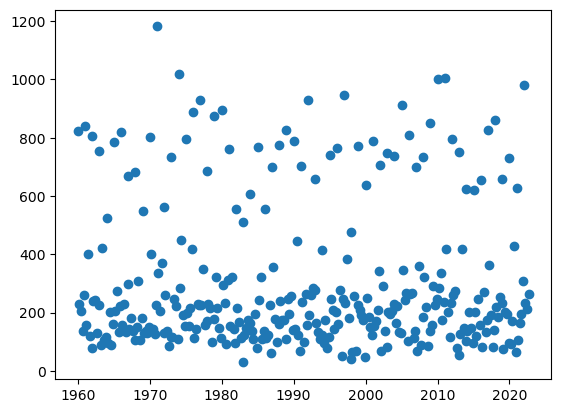

In [26]:
plt.scatter(df_rainfall.period_start,df_rainfall.precipitation)

# Daily rainfall

In [27]:
offset = datetime.timedelta(days=365*1.5)
base_start = datetime.datetime(1972,1,3)-offset
base_end = datetime.datetime(2021,12,31)-offset

wet_start = datetime.datetime(2018,7,1)-offset
wet_end = datetime.datetime(2019,6,30)-offset

dry_start = datetime.datetime(2020,7,1)-offset
dry_end = datetime.datetime(2021,6,30)-offset

In [28]:
df_rainfall_daily = pd.read_csv('daily_rainfall.csv')
df_rainfall_daily = df_rainfall_daily[df_rainfall_daily.site=="Napier (Hawke's Bay)"]
df_rainfall_daily['date'] = [datetime.datetime(int(x.split('/')[2]),int(x.split('/')[1]),int(x.split('/')[0])) for x in df_rainfall_daily.date]

In [29]:
df_rainfall_daily_base = df_rainfall_daily[(df_rainfall_daily.date>=base_start)&(df_rainfall_daily.date<=base_end)]
df_rainfall_daily_wet = df_rainfall_daily[(df_rainfall_daily.date>=wet_start)&(df_rainfall_daily.date<=wet_end)]
df_rainfall_daily_dry = df_rainfall_daily[(df_rainfall_daily.date>=dry_start)&(df_rainfall_daily.date<=dry_end)]

In [30]:
wet_avg = np.sum(df_rainfall_daily_wet.rainfall)/((dry_end-dry_start).days/365)
wet_avg

828.0686813186812

In [31]:
dry_avg = np.sum(df_rainfall_daily_dry.rainfall)/((wet_end-wet_start).days/365)
dry_avg

659.5068681318681

In [32]:
base_avg = np.sum(df_rainfall_daily_base.rainfall)/((base_end-base_start).days/365)
base_avg

753.8549288061337

# Defining Histogram of Precipitation

In [33]:

mean,var = stats.expon.fit(np.sort(list(df_rainfall_daily.rainfall))[:int(len(df_rainfall_daily.rainfall)*0.999999)])
i = 0
annual_precip_list = []
while i<10001:
    annual_precip_list.append(np.sum(stats.expon.rvs(loc=mean,scale=var,size=365)))
    i+=1

In [34]:
np.mean(annual_precip_list)

751.0953812722341

(array([  20.,  157.,  712., 1962., 2869., 2453., 1295.,  425.,   97.,
          11.]),
 array([611.43621622, 640.61974664, 669.80327707, 698.9868075 ,
        728.17033793, 757.35386835, 786.53739878, 815.72092921,
        844.90445964, 874.08799006, 903.27152049]),
 <BarContainer object of 10 artists>)

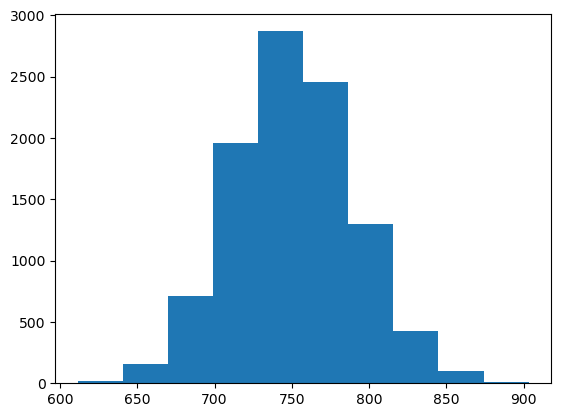

In [35]:
plt.hist(annual_precip_list)

In [36]:
mean,var = stats.norm.fit(annual_precip_list)

In [37]:
df_precip_change = pd.read_csv('HawkesBay_precip_projections.csv',encoding='utf-8')
df_precip_change = df_precip_change[df_precip_change.Year=='1986-2005 and 2081-2100']
df_precip_change

,rcp,Year,annual mean,5th percentile,95th percentile
4,8.5,1986-2005 and 2081-2100,-3.0,-15.0,13.0
5,6.0,1986-2005 and 2081-2100,-5.0,-72.0,10.0
6,4.5,1986-2005 and 2081-2100,-2.0,-18.0,8.0
7,2.6,1986-2005 and 2081-2100,-2.0,-9.0,4.0


In [38]:
p95 = stats.norm.ppf(0.95, loc=mean, scale=var)
p05 = stats.norm.ppf(0.05, loc=mean, scale=var)

In [39]:
mean_26 = mean+df_precip_change.loc[(df_precip_change.rcp==2.6),'annual mean'].values[0]
mean_45 = mean+df_precip_change.loc[(df_precip_change.rcp==4.5),'annual mean'].values[0]
mean_60 = mean+df_precip_change.loc[(df_precip_change.rcp==6.0),'annual mean'].values[0]
# mean_85 = mean+df_precip_change.loc[(df_precip_change.rcp==8.5),'annual mean'].values[0]

p95_26 = p95+df_precip_change.loc[(df_precip_change.rcp==2.6),'95th percentile'].values[0]
p95_45 = p95+df_precip_change.loc[(df_precip_change.rcp==4.5),'95th percentile'].values[0]
p95_60 = p95+df_precip_change.loc[(df_precip_change.rcp==6.0),'95th percentile'].values[0]
# p95_85 = p95+df_precip_change.loc[(df_precip_change.rcp==8.5),'95th percentile'].values[0]

p05_26 = p05+df_precip_change.loc[(df_precip_change.rcp==2.6),'5th percentile'].values[0]
p05_45 = p05+df_precip_change.loc[(df_precip_change.rcp==4.5),'5th percentile'].values[0]
p05_60 = p05+df_precip_change.loc[(df_precip_change.rcp==6.0),'5th percentile'].values[0]
# p05_85 = p05+df_precip_change.loc[(df_precip_change.rcp==8.5),'5th percentile'].values[0]

var_26 = (p95_26-p05_26)/(2*stats.norm.ppf(0.95))
var_45 = (p95_45-p05_45)/(2*stats.norm.ppf(0.95))
var_60 = (p95_60-p05_60)/(2*stats.norm.ppf(0.95))
# var_85 = (p95_85-p05_85)/(2*stats.norm.ppf(0.95))

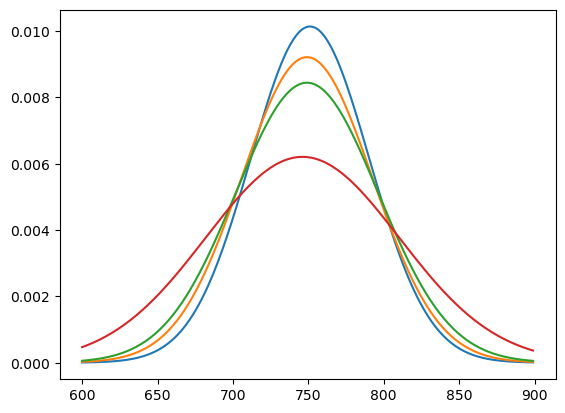

In [40]:
plt.plot(np.arange(600,900,1),stats.norm.pdf(np.arange(600,900,1),mean,var))
plt.plot(np.arange(600,900,1),stats.norm.pdf(np.arange(600,900,1),mean_26,var_26))
plt.plot(np.arange(600,900,1),stats.norm.pdf(np.arange(600,900,1),mean_45,var_45))
plt.plot(np.arange(600,900,1),stats.norm.pdf(np.arange(600,900,1),mean_60,var_60))
# plt.plot(np.arange(600,900,1),stats.norm.pdf(np.arange(600,900,1),mean_85,var_85))

In [41]:
dry_prob = stats.norm.cdf(np.mean([dry_avg,base_avg]),mean,var)
wet_prob = 1-stats.norm.cdf(np.mean([wet_avg,base_avg]),mean,var)
base_prob = 1-dry_prob-wet_prob

In [42]:
dry_26_prob = stats.norm.cdf(np.mean([dry_avg,base_avg]),mean_26,var_26)
wet_26_prob = 1-stats.norm.cdf(np.mean([wet_avg,base_avg]),mean_26,var_26)
base_26_prob = 1-dry_26_prob-wet_26_prob

In [43]:
dry_45_prob = stats.norm.cdf(np.mean([dry_avg,base_avg]),mean_45,var_45)
wet_45_prob = 1-stats.norm.cdf(np.mean([wet_avg,base_avg]),mean_45,var_45)
base_45_prob = 1-dry_45_prob-wet_45_prob

In [44]:
dry_60_prob = stats.norm.cdf(np.mean([dry_avg,base_avg]),mean_60,var_60)
wet_60_prob = 1-stats.norm.cdf(np.mean([wet_avg,base_avg]),mean_60,var_60)
base_60_prob = 1-dry_60_prob-wet_60_prob

In [45]:
# dry_85_prob = stats.norm.cdf(np.mean([dry_avg,base_avg]),mean_85,var_85)
# wet_85_prob = 1-stats.norm.cdf(np.mean([wet_avg,base_avg]),mean_85,var_85)
# base_85_prob = 1-dry_85_prob-wet_85_prob

In [46]:
stats.expon.pdf(wet_avg,mean,var)

0.003593012884586331

In [47]:
stats.expon.cdf(np.mean([dry_avg,base_avg]),mean,var)

0.0

In [48]:
stats.expon.cdf(np.mean([base_avg,wet_avg]),mean,var)

0.6369742396625975

In [49]:
stats.expon.pdf(base_avg,mean,var)

0.02369527571415041

In [50]:
df_rainfall_daily.rainfall

322154    0.0
322155    0.0
322156    1.0
322157    3.8
322158    2.2
         ... 
345160    0.0
345161    0.0
345162    0.0
345163    0.0
345164    0.0
Name: rainfall, Length: 23011, dtype: float64

In [51]:
np.percentile(df_rainfall_daily.rainfall,95)

11.7

In [52]:
np.percentile(df_rainfall_daily.rainfall,5)

0.0

# Plotting

In [53]:
xr_base

<xarray.Dataset>
Dimensions:      (i: 302, j: 501, k: 9, realization: 179)
Coordinates:
  * i            (i) int32 0 1 2 3 4 5 6 7 8 ... 294 295 296 297 298 299 300 301
  * j            (j) int32 0 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * k            (k) int32 0 1 2 3 4 5 6 7 8
    x            (i, j) float64 ...
    y            (i, j) float64 ...
    z            (k, i, j) float64 ...
  * realization  (realization) object '132' 'base' '12' ... '196' '197' '198'
Data variables:
    ib           (k, i, j) int32 ...
    top          (i, j) float64 ...
    botm         (k, i, j) float64 ...
    hds          (k, i, j) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:    HPM Regional groundwater model

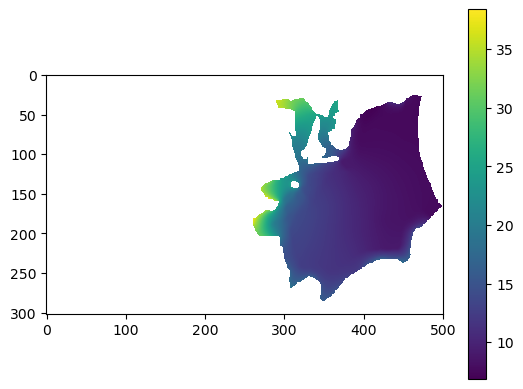

In [54]:
plt.imshow(xr_base.hds[-1,:,:])
plt.colorbar()

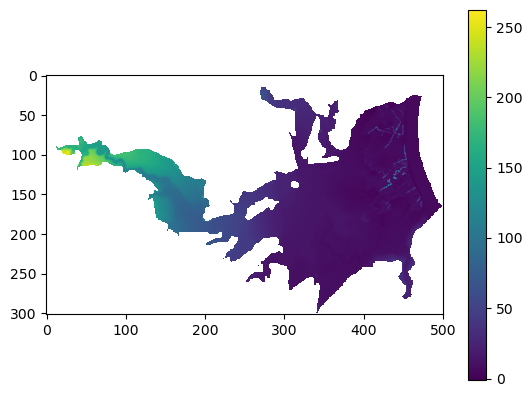

In [55]:
plt.imshow(xr_base.hds[0,:,:])
plt.colorbar()

In [56]:
def regrid_and_normalise(xr_heads):
    x = xr_heads['x'].values.flatten()
    y = xr_heads['y'].values.flatten()
    top = xr_heads.hds[0,:,:].values.flatten()
    
    min_val = 0
    max_val = 500

    unflattened_x = np.reshape(x,(len(xr_heads.i),len(xr_heads.j)))
    unflattened_y = np.reshape(y,(len(xr_heads.i),len(xr_heads.j)))
    unflattened_z = np.reshape(top,(len(xr_heads.i),len(xr_heads.j)))

    xr_test = xr.Dataset({
        'hds':(('y','x'),unflattened_z)
               },
              coords={
            'y': unflattened_y[:, 0],
            'x': unflattened_x[0, :]
        })

    xr_test = xr_test.rio.write_crs(2193)

    # Create a new CRS in EPSG:4326 (WGS 84)
    target_crs = rasterio.crs.CRS.from_epsg(4326)

    xr_test = xr_test.astype(float)
    # Reproject the xarray dataset to EPSG:4326

    xr_test_2 = xr_test.rio.reproject("EPSG:4326")

    filtered_array = np.array((xr_test_2.where(xr_test_2<10000,np.nan).where(xr_test_2>0,np.nan)).hds)
    normalised_array = np.ma.masked_invalid(filtered_array)
    # normalised_array = (normalised_array-normalised_array.min())/(normalised_array.max()-normalised_array.min())
    normalised_array = (normalised_array)/270#/(max_val-min_val)
    # get rid of all values exceeding the max
    normalised_array = np.ma.where(normalised_array>1,1,normalised_array)

    plt.imshow(normalised_array)
    
    return(xr_test_2,normalised_array,filtered_array)

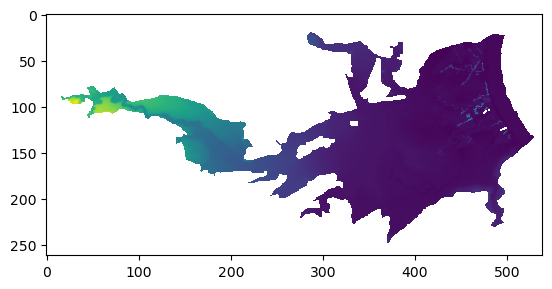

In [57]:
xr_base_regrid,normalised_base_array,base_filtered_array = regrid_and_normalise(xr_base)

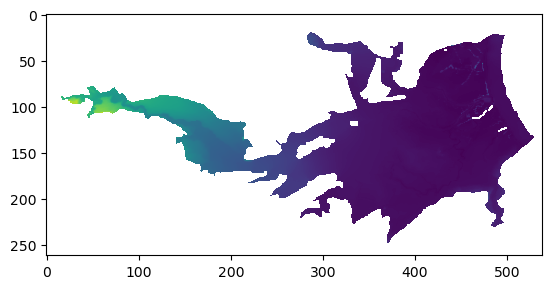

In [58]:
xr_dry_regrid,normalised_dry_array,dry_filtered_array = regrid_and_normalise(xr_dry)

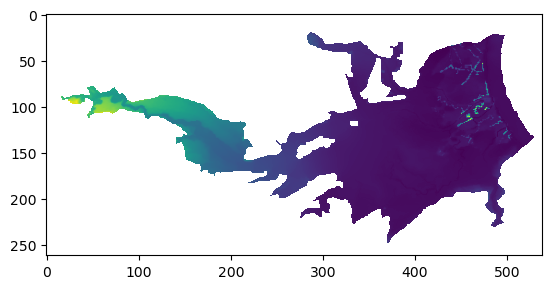

In [59]:
xr_wet_regrid,normalised_wet_array,wet_filtered_array = regrid_and_normalise(xr_wet)

# Health

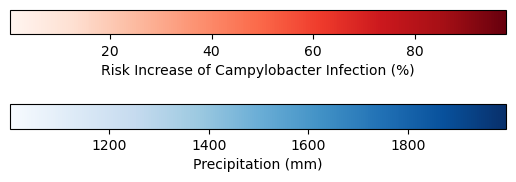

In [60]:
blue_cmap = plt.cm.get_cmap('Blues')
orange_cmap = plt.cm.get_cmap('Reds')

fig = plt.figure()
plt.imshow(np.random.random((10,10))*1000+1000,origin='lower',cmap=blue_cmap,interpolation='nearest')
cbar_blue = plt.colorbar(orientation='horizontal')
plt.imshow(np.random.random((10,10))*100,origin='lower',cmap=orange_cmap,interpolation='nearest')
cbar_orange = plt.colorbar(orientation='horizontal')
ax = plt.gca()        
ax.remove()
cbar_blue.ax.set_xlabel('Precipitation (mm)')
cbar_orange.ax.set_xlabel('Risk Increase of Campylobacter Infection (%)')
plt.savefig('precip_legend.png',bbox_inches='tight')



In [61]:

token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
location = [-40.708466, 172.198931]
map_osm = folium.Map(location=location, zoom_start=5)
custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox').add_to(map_osm)

lgd_txt = '<span style="color: {col};">{txt}</span>'

name = 'Q4 Precipitation'
fg2 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'),show=False)
folium.GeoJson(geojson_data_4,
               tooltip=folium.GeoJsonTooltip(fields=['Region','mean_precip'],aliases=['Region:','Monthly Mean Precipitation (mm):']),
               style_function=style_function_precip).add_to(fg2)
map_osm.add_child(fg2)

name = 'Q5 Precipitation'
fg3 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'),show=False)
folium.GeoJson(geojson_data_5,
               tooltip=folium.GeoJsonTooltip(fields=['Region','mean_precip'],aliases=['Region:','Monthly Mean Precipitation (mm):']),
               style_function=style_function_precip).add_to(fg3)
map_osm.add_child(fg3)

name = 'Risk increase under Q4 Precipitation'
fg4 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'),show=False)
folium.GeoJson(geojson_data_4,
               tooltip=folium.GeoJsonTooltip(fields=['Region','risk_increase'],aliases=['Region:','Risk Increase (%):']),
               style_function=style_function).add_to(fg4)
map_osm.add_child(fg4)

name = 'Risk increase under Q5 Precipitation'
fg5 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'),show=False)
folium.GeoJson(geojson_data_5,
               tooltip=folium.GeoJsonTooltip(fields=['Region','risk_increase'],aliases=['Region:','Risk Increase (%):']),
               style_function=style_function,overlay=False).add_to(fg5)
# map_osm.add_child(fg5)
fg5.add_to(map_osm)


# Define the HTML content for the button (you can customize the appearance and behavior here)
button_html = """
<div style="position: fixed; bottom: 10px; left: 10px; z-index: 1000; background-color: white; padding: 10px; border: 1px solid gray;">
    <a href="https://exchange.iseesystems.com/public/nicolamcdonald/deep-south-project-interface/index.html#Public_Health_&_Water_Quality/page3" target="_blank"><button style="cursor:pointer;">Back to systems diagram</button></a>
</div>
"""

# Inject the custom HTML element into the map's HTML representation
map_osm.get_root().html.add_child(folium.Element(button_html))


###################

# # Define the HTML content for the popup (you can customize the appearance and content here)
# popup_html = """
# <div style="position: fixed; bottom: 15px; right: 10px; z-index: 1000;width: 200px; height: 100px; background-color: white; border: 1px solid black; text-align: center;">
#     <p>This is a custom popup</p>
#     <p>This is for some explanation of the diagram.</p>
# </div>
# """

# map_osm.get_root().html.add_child(folium.Element(popup_html))

legend_html = """
<div style="position: fixed; bottom: 15px; right: 10px; z-index: 1000;width: 500px; height: 175px; background-color: white; border: 1px solid black; text-align: center;">
    <img src="{}" alt="Custom Image Overlay" width="450">
</div>
""".format("precip_legend.png")

map_osm.get_root().html.add_child(folium.Element(legend_html))

#######################

folium.LayerControl(name='Ground Water Output',collapsed=False).add_to(map_osm)   

map_osm.save('Campylobacter_risk.html')

# Formatting GW Variables 

In [62]:
realisations = list(gdf_base_sfo)
realisations.remove('geometry')
gdf_realisations_base = gdf_base_sfo[realisations]
gdf_base_sfo['mean'] = gdf_realisations_base.mean(axis=1)

realisations = list(gdf_wet_sfo)
realisations.remove('geometry')
gdf_realisations_wet = gdf_wet_sfo[realisations]
gdf_wet_sfo['mean'] = gdf_realisations_wet.mean(axis=1)

realisations = list(gdf_dry_sfo)
realisations.remove('geometry')
gdf_realisations_dry = gdf_dry_sfo[realisations]
gdf_dry_sfo['mean'] = gdf_realisations_dry.mean(axis=1)

In [63]:
realisations = list(gdf_base_sfx)
realisations.remove('geometry')
gdf_realisations_base = gdf_base_sfx[realisations]
gdf_base_sfx['mean'] = gdf_realisations_base.mean(axis=1)

realisations = list(gdf_wet_sfx)
realisations.remove('geometry')
gdf_realisations_wet = gdf_wet_sfx[realisations]
gdf_wet_sfx['mean'] = gdf_realisations_wet.mean(axis=1)

realisations = list(gdf_dry_sfx)
realisations.remove('geometry')
gdf_realisations_dry = gdf_dry_sfx[realisations]
gdf_dry_sfx['mean'] = gdf_realisations_dry.mean(axis=1)

In [64]:
min_value = 0#gdf_realisations.mean(axis=1).quantile(0.05)
max_value = np.max([gdf_dry_sfo['mean'].max(),gdf_base_sfo['mean'].max(),gdf_wet_sfo['mean'].max()])
# max_value = 250 # Set a new max value to get rid of some of the outliers

gdf_dry_sfo['mean_norm'] = gdf_dry_sfo['mean']/(max_value)
gdf_base_sfo['mean_norm'] = gdf_base_sfo['mean']/(max_value)
gdf_wet_sfo['mean_norm'] = gdf_wet_sfo['mean']/(max_value)

max_value_flux = np.max([gdf_dry_sfx['mean'].max(),gdf_base_sfx['mean'].max(),gdf_wet_sfx['mean'].max()])

gdf_dry_sfx['mean_norm'] = gdf_dry_sfx['mean']/(max_value_flux)
gdf_base_sfx['mean_norm'] = gdf_base_sfx['mean']/(max_value_flux)
gdf_wet_sfx['mean_norm'] = gdf_wet_sfx['mean']/(max_value_flux)


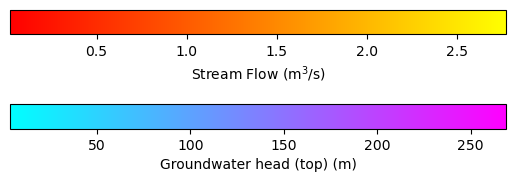

In [65]:
blue_cmap = plt.cm.get_cmap('cool')
autumn_cmap = plt.get_cmap('autumn')  # You can replace 'YlOrRd' with any other colormap available in matplotlib

# np.nanmax([np.nanmax(wet_filtered_array),np.nanmax(base_filtered_array),np.nanmax(dry_filtered_array)])

fig = plt.figure()
plt.imshow(np.random.random((10,10))*(270),origin='lower',cmap=blue_cmap,interpolation='nearest')
cbar_blue = plt.colorbar(orientation='horizontal')

plt.imshow(np.random.random((10,10))*max_value/10**6,origin='lower',cmap=autumn_cmap,interpolation='nearest')
cbar_autumn = plt.colorbar(orientation='horizontal')
ax = plt.gca()        
ax.remove()
cbar_blue.ax.set_xlabel('Groundwater head (top) (m)')
cbar_autumn.ax.set_xlabel('Stream Flow (m$^3$/s)')

plt.savefig('head.png',bbox_inches='tight')

plt.show()


In [66]:
def style_function_2(feature):
    # Replace 'your_color_column' with the actual column name you want to use for color mapping
    color_value = feature['properties']['mean_norm']
    color = autumn_cmap(color_value)
    hex_color = mcolors.rgb2hex(color)
    return {
        'color': hex_color,  # Apply the colormap to the line_color
        'weight': 2,      # Adjust line weight as needed
        'opacity': 1
    }

# Building a BN to connect the variables

In [67]:
def create_dataframe(gdf,name):
    df_for_mod = gdf.copy()
    df_for_mod = df_for_mod[['mean','geometry']]
    df_for_mod = df_for_mod.explode()
    df_for_mod.rename(columns={'mean':name},inplace=True)
    df_for_mod['coord1'] = [xy.coords[0] for xy in df_for_mod.geometry]
    df_for_mod['coord2'] = [xy.coords[1] for xy in df_for_mod.geometry]
    df_for_mod['x1'] = [x[0] for x in df_for_mod.coord1]
    df_for_mod['y1'] = [x[1] for x in df_for_mod.coord1]
    df_for_mod['x2'] = [x[0] for x in df_for_mod.coord2]
    df_for_mod['y2'] = [x[1] for x in df_for_mod.coord2]
    df_for_mod.drop(['coord1','coord2'],axis=1,inplace=True)
    
    return(df_for_mod)

df_base_sfo = create_dataframe(gdf_base_sfo,'flow')
df_base_sfx = create_dataframe(gdf_base_sfx,'flux').drop('geometry',axis=1)
df_dry_sfo = create_dataframe(gdf_dry_sfo,'flow')
df_dry_sfx = create_dataframe(gdf_dry_sfx,'flux').drop('geometry',axis=1)
df_wet_sfo = create_dataframe(gdf_wet_sfo,'flow')
df_wet_sfx = create_dataframe(gdf_wet_sfx,'flux').drop('geometry',axis=1)

In [68]:
realisations = list(gdf_base_sfo)
realisations = [x for x in realisations if x not in ['geometry']]

(array([149.,  17.,  10.,   2.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([0.0, 91.15578195, 182.3115639, 273.46734585, 364.6231278,
        455.77890975, 546.9346917, 638.09047365, 729.2462556, 820.40203755,
        911.5578195], dtype=object),
 <BarContainer object of 10 artists>)

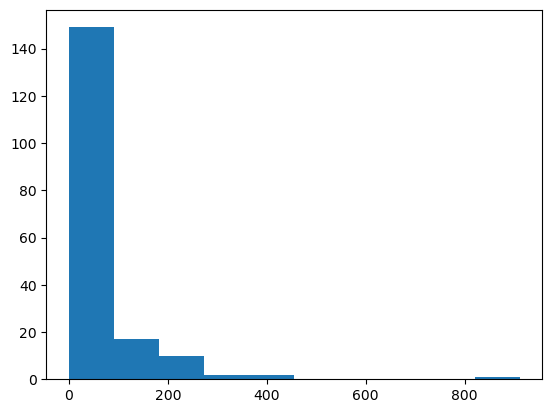

In [69]:
plt.hist(gdf_base_sfo.loc[0,:][realisations])

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate f

(array([ 2.,  0.,  1.,  3.,  0.,  1., 10., 24., 54., 86.]),
 array([-423.44372358, -380.42051432, -337.39730506, -294.3740958 ,
        -251.35088654, -208.32767728, -165.30446802, -122.28125876,
         -79.2580495 ,  -36.23484024,    6.78836902]),
 <BarContainer object of 10 artists>)

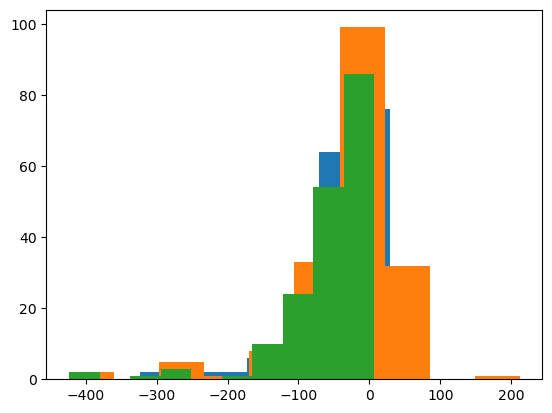

In [70]:
plt.hist(gdf_base_sfx.mean())
plt.hist(gdf_wet_sfx.mean())
plt.hist(gdf_dry_sfx.mean())

In [71]:
df_base_flow = pd.DataFrame(gdf_base_sfo.mean(),realisations,columns=['flow'])
df_wet_flow = pd.DataFrame(gdf_wet_sfo.mean(),realisations,columns=['flow'])
df_dry_flow = pd.DataFrame(gdf_dry_sfo.mean(),realisations,columns=['flow'])

df_base_flux = pd.DataFrame(gdf_base_sfx.mean(),realisations,columns=['flux'])
df_wet_flux = pd.DataFrame(gdf_wet_sfx.mean(),realisations,columns=['flux'])
df_dry_flux = pd.DataFrame(gdf_dry_sfx.mean(),realisations,columns=['flux'])


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate f

In [72]:
df_base = df_base_flow.join(df_base_flux)
df_base['recharge'] = 'base'

df_dry = df_dry_flow.join(df_dry_flux)
df_dry['recharge'] = 'dry'

df_wet = df_wet_flow.join(df_wet_flux)
df_wet['recharge'] = 'wet'

In [73]:
df_combined = df_wet.append(df_dry).append(df_base)

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate f

(array([ 1.,  0.,  0.,  8., 60., 80., 23.,  3.,  5.,  1.]),
 array([1.07316183e-01, 5.74621936e+04, 1.14924280e+05, 1.72386366e+05,
        2.29848452e+05, 2.87310539e+05, 3.44772625e+05, 4.02234711e+05,
        4.59696798e+05, 5.17158884e+05, 5.74620970e+05]),
 <BarContainer object of 10 artists>)

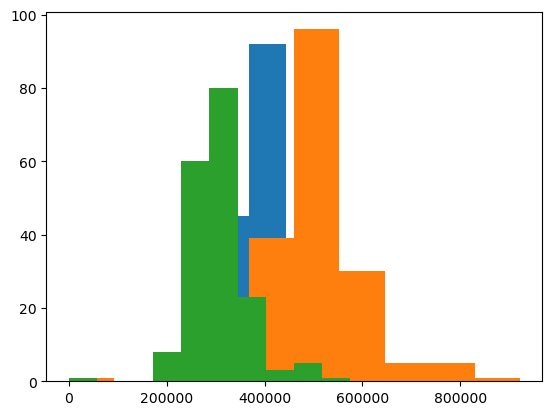

In [74]:
plt.hist(gdf_base_sfo.mean())
plt.hist(gdf_wet_sfo.mean())
plt.hist(gdf_dry_sfo.mean())

#### Add recharge values to each of these

In [75]:
base_rch = 0.000682678
wet_rch = 0.00138925
dry_rch = 0.000299198

# Create a very basic two node network

In [76]:
df_combined = df_wet.append(df_dry).append(df_base)
# df_combined = df_combined[['flow','flux','Recharge']]
df_combined.columns = ['StreamFlow','Flux','Recharge']
df_combined = df_combined[df_combined.Flux!=0]
# df_combined.loc[:,'Flux'] = np.abs(df_combined['Flux'])

# bins_streamflow = [0,2*10**6,2.3*10**6,4*10**6]
bins_absflux = [-400,-50,0,20,200]

bins_streamflow = [df_combined.StreamFlow.quantile(0)-1,df_combined.StreamFlow.quantile(0.33),df_combined.StreamFlow.quantile(0.67),df_combined.StreamFlow.quantile(1)+1]
# bins_absflux = [df_combined.Flux.quantile(0)-1,df_combined.Flux.quantile(0.33),df_combined.Flux.quantile(0.67),df_combined.Flux.quantile(1)+1]

df_combined['StreamFlow'] = pd.cut(df_combined.StreamFlow,bins_streamflow,labels=['Low','Medium','High'])
df_combined['Flux'] = pd.cut(df_combined.Flux,bins_absflux,labels=['Low','Medium','High','VeryHigh'])
# df_combined['Recharge'] = pd.cut(df_combined.Recharge,bins_rch,labels=['dry','base','wet'])
df_combined = df_combined.dropna(axis=0)

In [77]:
df_combined['Recharge'] = df_combined.Recharge.replace('base','Base')
df_combined['Recharge'] = df_combined.Recharge.replace('dry','Dry')
df_combined['Recharge'] = df_combined.Recharge.replace('wet','Wet')

In [78]:
net = pysmile.Network()
net.add_node(pysmile.NodeType.CPT,'Flux')
net.add_node(pysmile.NodeType.CPT,'StreamFlow')
net.add_node(pysmile.NodeType.CPT,'Recharge')

for node in net.get_all_node_ids():
    if (node != 'Recharge')&(node!='Flux'):
        for outcome in ['Low','Medium','High']:
            net.add_outcome(node,outcome)
    elif node == 'Recharge':
        for outcome in ['Dry','Base','Wet']:
            net.add_outcome(node,outcome)
    else:
        for outcome in ['Low','Medium','High','VeryHigh']:#['verylow','low','medium','high','veryhigh']:
            net.add_outcome(node,outcome)
        
    net.delete_outcome(node,'State0')
    net.delete_outcome(node,'State1')
    
net.add_arc('StreamFlow','Flux')
net.add_arc('Recharge','StreamFlow')
net.add_arc('Recharge','Flux')

df_combined.to_csv('training_data.csv',index=False)

dataset = pysmile.learning.DataSet()
dataset.read_file('training_data.csv')
matching = dataset.match_network(net)
em = pysmile.learning.EM()
em.learn(dataset,net,matching)

## Add in the RCP nodes
net.add_node(pysmile.NodeType.CPT,'ClimateScenario')

net.add_arc('ClimateScenario','Recharge')

for outcome in ['Present','RCP26','RCP45','RCP60']:
    net.add_outcome('ClimateScenario',outcome)
    
net.delete_outcome('ClimateScenario','State0')
net.delete_outcome('ClimateScenario','State1')

net.set_node_definition('ClimateScenario',[0.25,0.25,0.25,0.25])

In [79]:
cpt = [dry_prob,
base_prob,
wet_prob,
dry_26_prob,
base_26_prob,
wet_26_prob,
dry_45_prob,
base_45_prob,
wet_45_prob,
dry_60_prob,
base_60_prob,
wet_60_prob]#,
# dry_85_prob,
# base_85_prob,
# wet_85_prob]

In [80]:
net.set_node_definition('Recharge',cpt)

In [81]:
net.write_file('flux.xdsl')

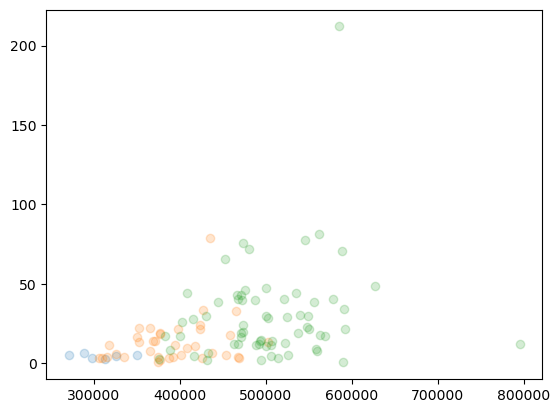

In [82]:
df_dry_pos = df_dry[df_dry.flux>0]
df_base_pos = df_base[df_base.flux>0]
df_wet_pos = df_wet[df_wet.flux>0]

plt.scatter(df_dry_pos.flow,np.abs(df_dry_pos.flux),alpha=0.2)
plt.scatter(df_base_pos.flow,np.abs(df_base_pos.flux),alpha=0.2)
plt.scatter(df_wet_pos.flow,np.abs(df_wet_pos.flux),alpha=0.2)

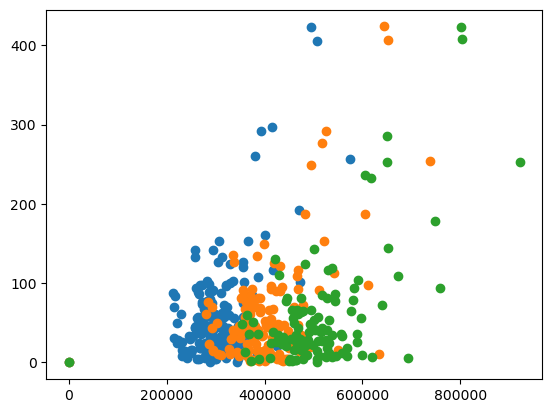

In [83]:
df_dry_pos = df_dry[df_dry.flux<0]
df_base_pos = df_base[df_base.flux<0]
df_wet_pos = df_wet[df_wet.flux<0]

plt.scatter(df_dry_pos.flow,np.abs(df_dry_pos.flux))
plt.scatter(df_base_pos.flow,np.abs(df_base_pos.flux))
plt.scatter(df_wet_pos.flow,np.abs(df_wet_pos.flux))

In [84]:
# df_base[['x1','y1','x2','y2']] = round(df_base[['x1','y1','x2','y2']],5)

In [85]:
# [df_base[(x1==df_base.x2)&(y1==df_base.y2)] for x1,y1 in zip(df_base.x1,df_base.y2)]

In [86]:
# closest_index_dict = {}
# for index,row in df_base.iterrows():
#     square_error = ((row.x2-df_base.x1)**2+(row.y2-df_base.y1)**2).drop(index)
#     asdf
#     if square_error.min()>0.1:
#         row['next'] = np.nan
#     else:
#         closest_downstream = square_error.idxmin()
#         row['next'] = closest_downstream
#     closest_index_dict.update({
#         index:row
#     })
    
# df_closest = pd.DataFrame.from_dict(closest_index_dict,orient='index')

# Converting BN to PNG

In [87]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


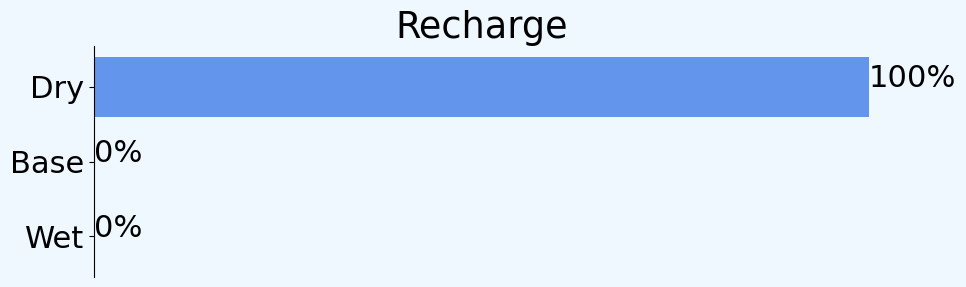

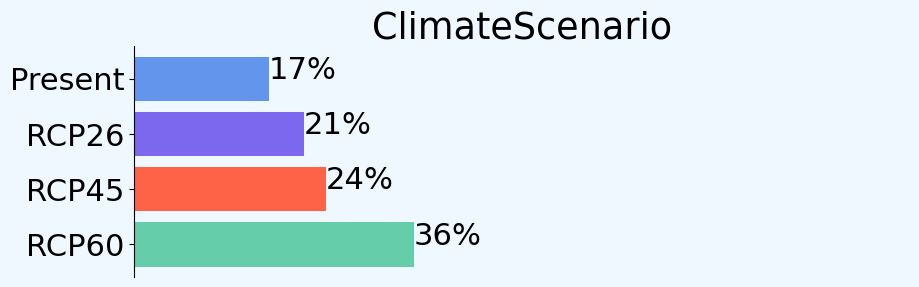

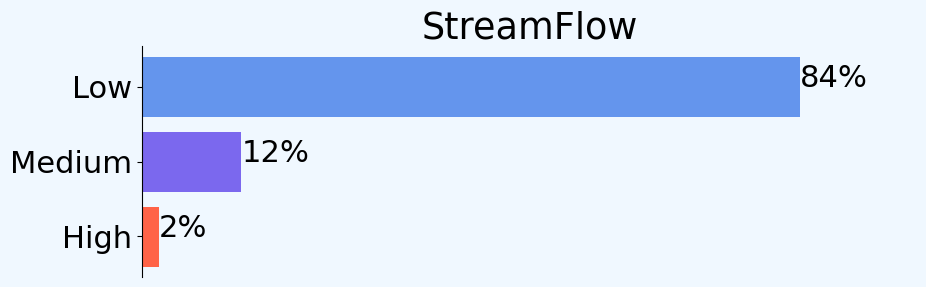

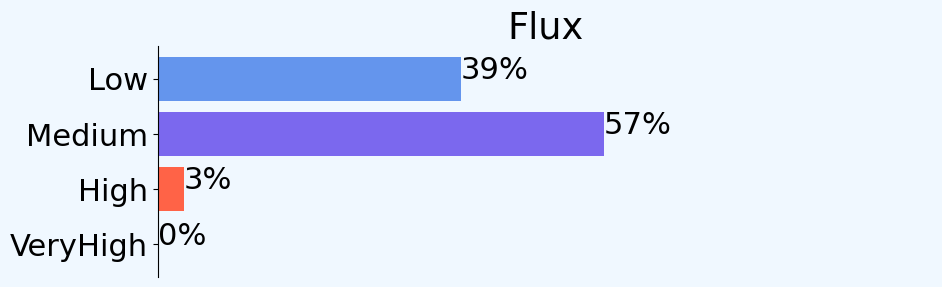

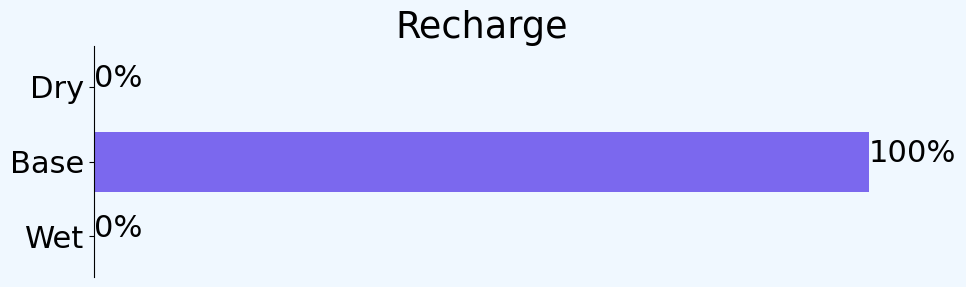

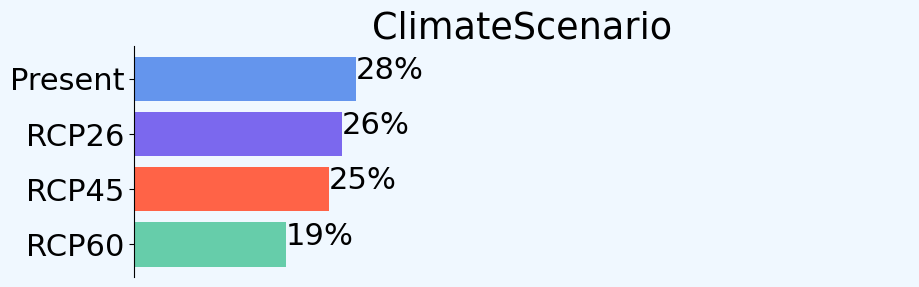

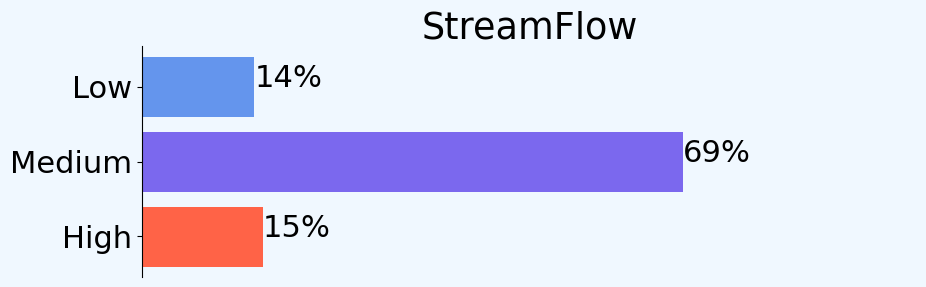

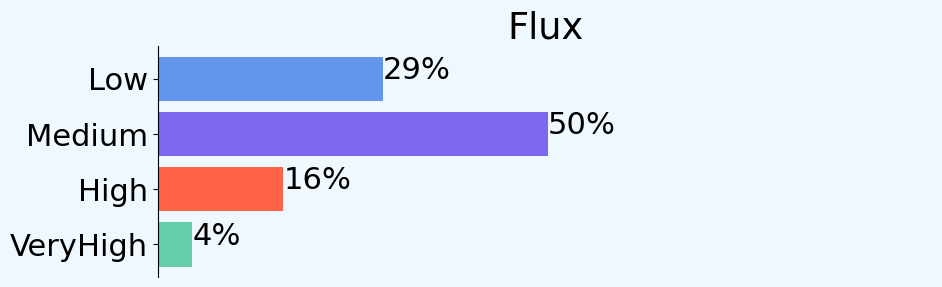

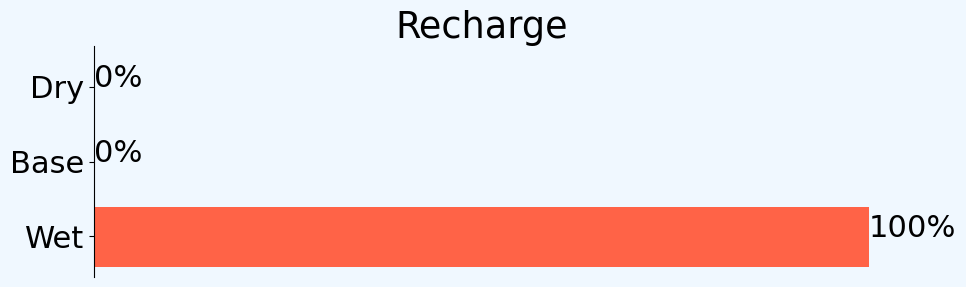

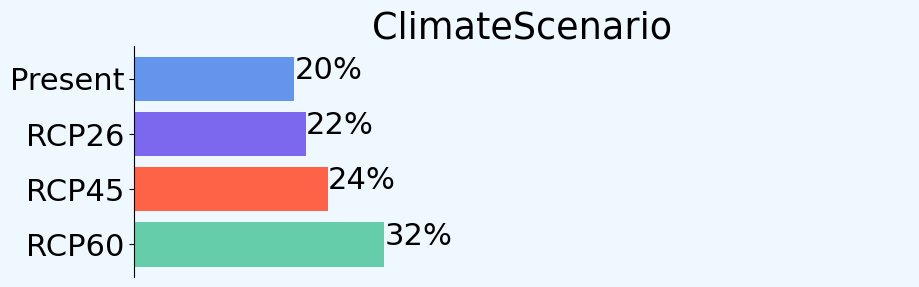

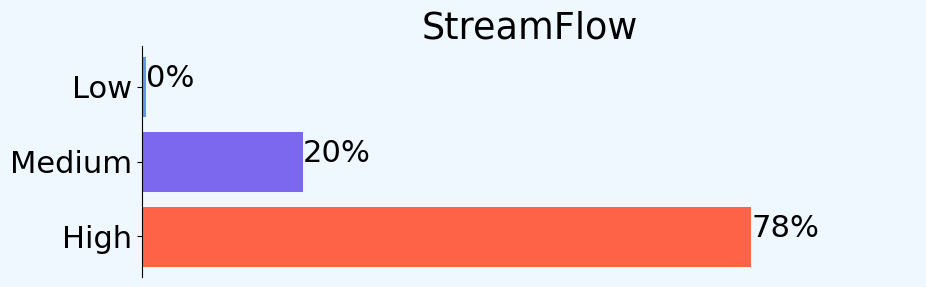

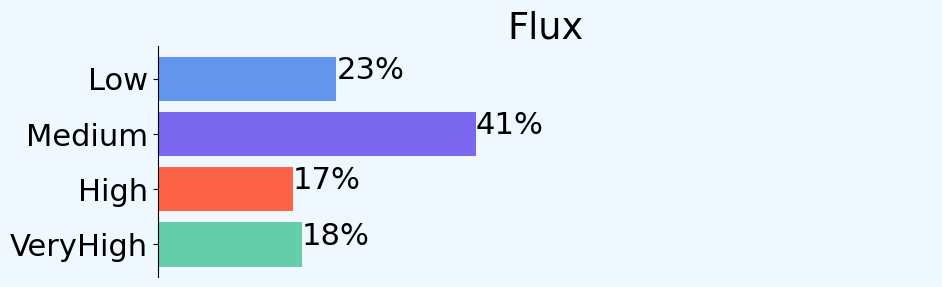

In [88]:
outcomes = net.get_outcome_ids('Recharge')
colors = ['cornflowerblue','mediumslateblue','tomato','mediumaquamarine']

for outcome in outcomes:
    net.clear_all_evidence()
    evidence = [1 if outcome is x else 0 for x in outcomes]
    net.set_virtual_evidence('Recharge',evidence)
    net.update_beliefs()
    
    fig = plt.figure(figsize=(10,3))
    ax1 = plt.subplot2grid((1,1),(0,0))
    ax1.barh(y=[0,1,2],width=evidence,color=colors)
    ax1.set_yticks([0,1,2])
    ax1.set_yticklabels(net.get_outcome_ids('Recharge'))
    ax1.set_xlim([0,1])
    ax1.invert_yaxis()
    for o,result in zip([0,1,2],evidence):
        ax1.text(result,o,f'{int(result*100)}%')
    ax1.spines[['right', 'top','bottom']].set_visible(False)
    ax1.set_xticks([])
    ax1.set_title('Recharge')
    # plt.subplots_adjust(left=0.5, right=0.5, top=0.5, bottom=0.5)
    ax1.set_facecolor('none')
    fig.set_facecolor("aliceblue")
    plt.savefig(f'additional_figs/Recharge_{outcome}.png',bbox_inches='tight')
    
    results = net.get_node_value('ClimateScenario')
    fig = plt.figure(figsize=(10,3))
    ax1 = plt.subplot2grid((1,1),(0,0))
    ax1.barh(y=[0,1,2,3],width=results,color=colors)
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(net.get_outcome_ids('ClimateScenario'))
    ax1.set_xlim([0,1])
    ax1.invert_yaxis()
    for o,result in zip([0,1,2,3],results):
        ax1.text(result,o,f'{int(result*100)}%')
    ax1.spines[['right', 'top','bottom']].set_visible(False)
    ax1.set_xticks([])
    ax1.set_title('ClimateScenario')
    ax1.set_facecolor('none')
    fig.set_facecolor("aliceblue")
    plt.savefig(f'additional_figs/ClimateScenario_{outcome}.png',bbox_inches='tight')
    
    results = net.get_node_value('StreamFlow')
    fig = plt.figure(figsize=(10,3))
    ax1 = plt.subplot2grid((1,1),(0,0))
    ax1.barh(y=[0,1,2],width=results,color=colors)
    ax1.set_yticks([0,1,2])
    ax1.set_yticklabels(net.get_outcome_ids('StreamFlow'))
    ax1.set_xlim([0,1])
    ax1.invert_yaxis()
    for o,result in zip([0,1,2],results):
        ax1.text(result,o,f'{int(result*100)}%')
    ax1.spines[['right', 'top','bottom']].set_visible(False)
    ax1.set_xticks([])
    ax1.set_title('StreamFlow')
    ax1.set_facecolor('none')
    fig.set_facecolor("aliceblue")
    plt.savefig(f'additional_figs/StreamFlow_{outcome}.png',bbox_inches='tight')
    
    results = net.get_node_value('Flux')
    fig = plt.figure(figsize=(10,3))
    ax1 = plt.subplot2grid((1,1),(0,0))
    ax1.barh(y=[0,1,2,3],width=results,color=colors)
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(net.get_outcome_ids('Flux'))
    ax1.set_xlim([0,1])
    ax1.invert_yaxis()
    for o,result in zip([0,1,2,3],results):
        ax1.text(result,o,f'{int(result*100)}%')
    ax1.spines[['right', 'top','bottom']].set_visible(False)
    ax1.set_xticks([])
    ax1.set_title('Flux')
    ax1.set_facecolor('none')
    fig.set_facecolor("aliceblue")
    plt.savefig(f'additional_figs/Flux_{outcome}.png',bbox_inches='tight')

    

In [89]:
for outcome in net.get_outcome_ids('Recharge'):
    xml_file = 'flux.xdsl'  # Replace with your XML file path
    output_file = f'flux_{outcome}'

    tree = ET.parse(xml_file)
    # tree = tree.findall('nodes')[0]
    root = tree.findall('nodes')[0]#tree.getroot()

    dot = Digraph(comment='XML Tree')
    dot.attr('edge', penwidth='10')
    dot.attr('node', penwidth='2')
    dot.attr(layout='neato',iterations='10000')

    for child in list(root):
        dot.node(child.attrib['id'],label='',image=f"additional_figs/{child.attrib['id']}_{outcome}.png",shape='box',
                 width='1.5',height='0.3',
                style='filled', fillcolor='invis',imagepos='c')
        for parent in child.findall('parents'):
            for txt in parent.text.split(' '):
                dot.edge(txt,child.attrib['id'])
                # ,image=f"additional_figs/{child.attrib['id']}_{outcome}.png",
            
    pos_list = ['10,15!','10,10!','2.5,5!','17.5,5!']
    with dot.subgraph(name='cluster_name') as cluster:
            for child,pos in zip(list(root),pos_list):
                cluster.node(child.attrib['id'],image=f"additional_figs/{child.attrib['id']}_{outcome}.png",label='',width='1.5',height='0.3',shape='box',imagepos='c',
                            pos=pos)
            cluster.graph_attr['margin'] = '1'  # Adjust the margin to increase the padding
            cluster.graph_attr['pad'] = '1' # Adjust the pad attribute as needed
            
    dot.attr('node', style='filled', setlinewidth='200')
    dot.attr('node', penwidth='10000')
    dot.format = 'png'
    # dot.graph_attr['dpi'] = '200'
    dot.render(output_file, view=False)
    


In [90]:
# for outcome in net.get_outcome_ids('Recharge'):
#     xml_file = 'flux.xdsl'  # Replace with your XML file path
#     output_file = f'flux_{outcome}'

#     tree = ET.parse(xml_file)
#     # tree = tree.findall('nodes')[0]
#     root = tree.findall('nodes')[0]#tree.getroot()

#     dot = Digraph(comment='XML Tree')
#     dot.attr('edge', penwidth='3')
#     dot.attr('node', penwidth='3')

#     for child in list(root):
#         dot.node(child.attrib['id'],shape='box',
#                 style='filled', fillcolor='blue')
#         for parent in child.findall('parents'):
#             for txt in parent.text.split(' '):
#                 dot.edge(txt,child.attrib['id'])
            
#     with dot.subgraph(name='cluster_name') as cluster:
#             for child in list(root):
#                 cluster.node(child.attrib['id'],shape='box')
#             cluster.graph_attr['margin'] = '100'  # Adjust the margin to increase the padding
#             cluster.graph_attr['pad'] = '1' # Adjust the pad attribute as needed
            
#     dot.attr('node', style='filled', setlinewidth='200')
#     dot.attr('node', penwidth='10000')
#     dot.format = 'png'
#     dot.render(output_file, view=True)
    


In [91]:
'part'.split(' ')

['part']

# Ground Water

In [92]:

token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
location = [-39.590722, 176.825091]
map_osm = folium.Map(location=location, zoom_start=11)
custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox',overlay=False).add_to(map_osm)

lgd_txt = '<span style="color: {col};">{txt}</span>'

fg1 = folium.FeatureGroup(name= lgd_txt.format( txt='Dry', col= 'Red'),overlay=True,show=False)
fg2 = folium.FeatureGroup(name= lgd_txt.format( txt='Base', col= 'Black'),overlay=True,show=False)
fg3 = folium.FeatureGroup(name= lgd_txt.format( txt='Wet', col= 'Blue'),overlay=True,show=False)

map_osm.add_child(fg1)
map_osm.add_child(fg2)
map_osm.add_child(fg3)


js_code = """
var overlays = {};
map.on('overlayadd', function(eventLayer){
    overlays[eventLayer.name] = eventLayer.layer;
    for (var name in overlays) {
        if (name !== eventLayer.name) {
            map.removeLayer(overlays[name]);
        }
    }
});
"""

folium.LayerControl(name='Ground Water Output',collapsed=False).add_to(map_osm)  

# folium.map.CustomPane('mapjs').add_to(map_osm)
# map_osm.get_root().html.add_child(folium.Element('<script>' + js_code + '</script>'))



folium.GeoJson(
    gdf_dry_sfo,
    name='geojsoon',
    style_function=style_function_2
).add_to(fg1)
folium.raster_layers.ImageOverlay(blue_cmap(normalised_dry_array),
                                  [[xr_dry_regrid.y.values.min(), xr_dry_regrid.x.values.min()],
                                   [xr_dry_regrid.y.values.max(), xr_dry_regrid.x.values.max()]],opacity=0.5).add_to(fg1)


folium.GeoJson(
    gdf_base_sfo,
    name='geojson',
    style_function=style_function_2
).add_to(fg2)
folium.raster_layers.ImageOverlay(blue_cmap(normalised_base_array),
                                  [[xr_base_regrid.y.values.min(), xr_base_regrid.x.values.min()],
                                   [xr_base_regrid.y.values.max(), xr_base_regrid.x.values.max()]],opacity=0.5).add_to(fg2)


folium.GeoJson(
    gdf_wet_sfo,
    name='geojson',
    style_function=style_function_2
).add_to(fg3)
folium.raster_layers.ImageOverlay(blue_cmap(normalised_wet_array),
                                  [[xr_wet_regrid.y.values.min(), xr_wet_regrid.x.values.min()],
                                   [xr_wet_regrid.y.values.max(), xr_wet_regrid.x.values.max()]],opacity=0.5).add_to(fg3)



##########

# Define the HTML content for the button (you can customize the appearance and behavior here)
button_html = """
<div style="position: fixed; bottom: 10px; left: 10px; z-index: 1000; background-color: white; padding: 10px; border: 1px solid gray;">
    <a href="https://exchange.iseesystems.com/public/nicolamcdonald/deep-south-project-interface/index.html#Hydrological_System/page5" target="_blank"><button style="cursor:pointer;">Back to systems diagram</button></a>
</div>
"""

# Inject the custom HTML element into the map's HTML representation
map_osm.get_root().html.add_child(folium.Element(button_html))


###################
# location_bn = [-39.585542, 177.374628]
# ic = 400
# # Define the HTML content for the popup (you can customize the appearance and content here)
# # custom_icon = folium.features.CustomIcon("flux_low.png", icon_size=(ic, ic))

# custom_icon = folium.features.CustomIcon("flux_low.png", icon_size=(ic, ic))
# marker = folium.Marker(location_bn, icon=custom_icon)
# fg1.add_child(marker)

# custom_icon = folium.features.CustomIcon("flux_medium.png", icon_size=(ic, ic))
# marker = folium.Marker(location_bn, icon=custom_icon)
# fg2.add_child(marker)

# custom_icon = folium.features.CustomIcon("flux_high.png", icon_size=(ic, ic))
# marker = folium.Marker(location_bn, icon=custom_icon)
# fg3.add_child(marker)

# Add the marker to the map

legend_html = """
<div style="position: fixed; bottom: 15px; right: 10px; z-index: 1000;width: 500px; height: 175px; background-color: white; border: 1px solid black; text-align: center;">
    <img src="{}" alt="Custom Image Overlay" width="450">
</div>
""".format("head.png")

map_osm.get_root().html.add_child(folium.Element(legend_html))

map_osm.get_root().html.add_child(folium.Element("""
    <script>
        var overlays = document.getElementsByClassName('leaflet-control-layers-overlays')[0];
        var checkboxes = overlays.getElementsByTagName('input');
        for (var i = 0; i < checkboxes.length; i++) {
            checkboxes[i].onclick = function() {
                for (var j = 0; j < checkboxes.length; j++) {
                    if (checkboxes[j] !== this && checkboxes[j].checked) {
                        checkboxes[j].checked = false;
                    }
                }
            };
        }
    </script>
"""))


####################### 

map_osm.save('groundwater.html')


In [93]:
# There needs to be a base state ammended

In [94]:

token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
location = [-39.617230, 177.330883]
custom_tile_layer = folium.TileLayer(tiles="", name='Bayesian Network Toggle',attr='Mapbox',overlay=False).add_to(fg1)
map_osm = folium.Map(location=location, zoom_start=11,tiles=custom_tile_layer)
# custom_tile_layer = folium.TileLayer(tiles="", name='Satellite',attr='Mapbox',overlay=False).add_to(map_osm)

lgd_txt = '<span style="color: {col};">{txt}</span>'

fg1 = folium.FeatureGroup(name= lgd_txt.format( txt='Dry', col= 'Black'),overlay=True,show=False)
fg2 = folium.FeatureGroup(name= lgd_txt.format( txt='Base', col= 'Black'),overlay=True,show=False)
fg3 = folium.FeatureGroup(name= lgd_txt.format( txt='Wet', col= 'Black'),overlay=True,show=False)
# fg4 = folium.FeatureGroup(name= lgd_txt.format( txt='RCP 6.0', col= 'Black'),overlay=True,show=False)
# fg5 = folium.FeatureGroup(name= lgd_txt.format( txt='RCP 8.5', col= 'Black'),overlay=True,show=False)

map_osm.add_child(fg1)
map_osm.add_child(fg2)
map_osm.add_child(fg3)
# map_osm.add_child(fg4)
# map_osm.add_child(fg5)

js_code = """
var overlays = {};
map.on('overlayadd', function(eventLayer){
    overlays[eventLayer.name] = eventLayer.layer;
    for (var name in overlays) {
        if (name !== eventLayer.name) {
            map.removeLayer(overlays[name]);
        }
    }
});
"""

folium.LayerControl(name='Ground Water Output',collapsed=False).add_to(map_osm)  

# folium.map.CustomPane('mapjs').add_to(map_osm)
# map_osm.get_root().html.add_child(folium.Element('<script>' + js_code + '</script>'))



###################
location_bn = [-39.585542, 177.374628]
ic = 400
# Define the HTML content for the popup (you can customize the appearance and content here)
# custom_icon = folium.features.CustomIcon("flux_low.png", icon_size=(ic, ic))

custom_icon = folium.features.CustomIcon("flux_Dry.png", icon_size=(ic, ic))
marker = folium.Marker(location_bn, icon=custom_icon)
fg1.add_child(marker)

custom_icon = folium.features.CustomIcon("flux_base.png", icon_size=(ic, ic))
marker = folium.Marker(location_bn, icon=custom_icon)
fg2.add_child(marker)

custom_icon = folium.features.CustomIcon("flux_Wet.png", icon_size=(ic, ic))
marker = folium.Marker(location_bn, icon=custom_icon)
fg3.add_child(marker)

# custom_icon = folium.features.CustomIcon("flux_rcp60.png", icon_size=(ic, ic))
# marker = folium.Marker(location_bn, icon=custom_icon)
# fg4.add_child(marker)

# custom_icon = folium.features.CustomIcon("flux_rcp85.png", icon_size=(ic, ic))
# marker = folium.Marker(location_bn, icon=custom_icon)
# fg5.add_child(marker)

# # Change this 'marker' to be a base state
# custom_icon = folium.features.CustomIcon("flux_base.png", icon_size=(ic, ic))
# marker = folium.Marker(location_bn, icon=custom_icon)
# map_osm.add_child(marker)


####################### 

map_osm.save('groundwater_BN.html')
